In [17]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import StandardScaler
import random
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy.spatial.distance import mahalanobis
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN

In [18]:
random.seed(42)

In [19]:
path = r"D:\UOM\Semester 2\Advanced ML\Asssignments\Research project\PIMA_India\diabetes.csv"
df = pd.read_csv(path)

In [20]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [21]:
df.info(),

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


(None,)

In [22]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [23]:
df['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

## Replicate the Methodology in below article 
Diabetic Prediction based on Machine Learning Using PIMA Indian Dataset 

link : https://www.researchgate.net/profile/Subhi-Zeebaree/publication/382399289_Diabetic_Prediction_based_on_Machine_Learning_Using_PIMA_Indian_Dataset/links/669ba3d9cb7fbf12a45fc538/Diabetic-Prediction-based-on-Machine-Learning-Using-PIMA-Indian-Dataset.pdf

#### Preprocessig

##### Impute missing values

The 0 values  in below columns indicate missing values
'Pregnancies',
'Glucose',
'BloodPressure',
'SkinThickness',
'Insulin',
'BMI',
'DiabetesPedigreeFunction',
'Age'

In [24]:
columns_to_check = [
    'Glucose',
    'BloodPressure',
    'SkinThickness',
    'Insulin',
    'BMI',
    'DiabetesPedigreeFunction',
    'Age'
]

# Count 0s in each column
zero_counts = (df[columns_to_check] == 0).sum()
print(zero_counts)


Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
dtype: int64


In [25]:
# # Replace missing values with mean
# df['Glucose'] = df['Glucose'].replace(0, np.mean(df['Glucose'])) 
# df['BloodPressure'] = df['BloodPressure'].replace(0, np.mean(df['BloodPressure'])) 
# df['SkinThickness'] = df['SkinThickness'].replace(0, np.mean(df['SkinThickness'])) 
# df['Insulin'] = df['Insulin'].replace(0, np.mean(df['Insulin'])) 
# df['BMI'] = df['BMI'].replace(0, np.mean(df['BMI'])) 

##### Improvement :Replace missing values with the mean value of the corresponding outcome 

In [26]:
columns_to_replace = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Replace zeros with mean within each Outcome group
for col in columns_to_replace:
    for outcome_value in [0, 1]:
        # Calculate mean for this group, ignoring zeros
        mean_val = df[(df['Outcome'] == outcome_value) & (df[col] != 0)][col].mean()
        
        # Replace zeros only in this group
        df.loc[(df['Outcome'] == outcome_value) & (df[col] == 0), col] = mean_val



C:\Users\geesa\AppData\Local\Temp\ipykernel_32664\2933723807.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '110.64386317907444' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[(df['Outcome'] == outcome_value) & (df[col] == 0), col] = mean_val
C:\Users\geesa\AppData\Local\Temp\ipykernel_32664\2933723807.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '70.87733887733887' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[(df['Outcome'] == outcome_value) & (df[col] == 0), col] = mean_val
C:\Users\geesa\AppData\Local\Temp\ipykernel_32664\2933723807.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '27.235457063711912' has dtype incompatible w

##### Standardization

In [27]:
# Columns to standardize
features_to_standardize = [
    'Pregnancies', 'Glucose', 'BloodPressure',
    'SkinThickness', 'Insulin', 'BMI',
    'DiabetesPedigreeFunction', 'Age'
]
scaler = StandardScaler()

# Fit and transform the data
df[features_to_standardize] = scaler.fit_transform(df[features_to_standardize])


### Improvements

#### Outlier detection in multivariate space using mahalanobis distance

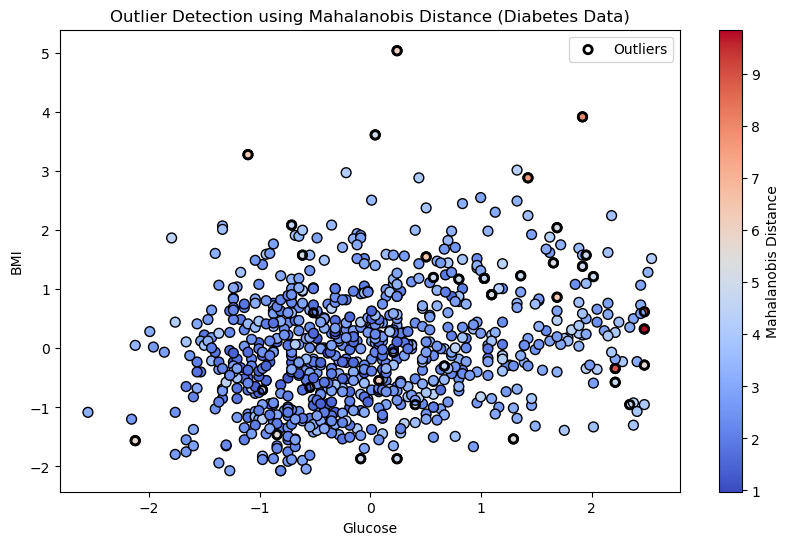

In [28]:
# Select features to compute Mahalanobis distance
selected_cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age','Outcome']

data = df[selected_cols].copy()
data = data.dropna()

# Calculate mean and covariance
mean = np.mean(data, axis=0)
cov = np.cov(data.T)
inv_covmat = np.linalg.inv(cov)

# Compute Mahalanobis distance for each row
mahal_dist = [mahalanobis(row, mean, inv_covmat) for row in data.values]

# Add distances to the original DataFrame
data['mahal_dist'] = mahal_dist

# Define a threshold (e.g., 95th percentile) for outliers
threshold = np.percentile(mahal_dist, 95)
data['outlier'] = data['mahal_dist'] > threshold

# Scatter plot using 2 selected features (Glucose vs BMI)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data['Glucose'], data['BMI'], c=data['mahal_dist'], cmap='coolwarm', s=50, edgecolor='k')
plt.colorbar(scatter, label='Mahalanobis Distance')
plt.xlabel('Glucose')
plt.ylabel('BMI')
plt.title('Outlier Detection using Mahalanobis Distance (Diabetes Data)')

# Mark outliers
outliers = data[data['outlier']]
plt.scatter(outliers['Glucose'], outliers['BMI'], facecolors='none', edgecolors='black', linewidths=2, label='Outliers')

plt.legend()
plt.show()


In [29]:
#Merge back with original df 
outliers_df = df.loc[data['outlier'].values].copy()
print("Number of outliers:", len(outliers_df))
print(outliers_df)

Number of outliers: 39
     Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
4      -1.141852  0.502679      -2.680419       0.645088  0.123830  1.549727   
8      -0.547919  2.473629      -0.200703       1.766404  4.346658 -0.283137   
13     -0.844885  2.210836      -1.027275      -0.700491  7.758703 -0.341323   
18     -0.844885 -0.614193      -3.506991       0.981483 -0.833344  1.578820   
45     -1.141852  1.915193      -0.531332       1.093614  0.561272  1.389715   
57     -1.141852 -0.712740       1.287126       3.448377 -0.529301  2.087948   
58     -1.141852  0.798322       0.791183      -0.225562 -0.300842  1.171517   
86      2.718712 -0.515645      -0.035389       2.775587 -0.300842  0.604202   
106    -0.844885 -0.844137       4.097471      -0.225562 -0.300842 -1.461406   
125    -0.844885 -1.106930      -3.506991       1.430009 -0.653170  3.280764   
129    -1.141852 -0.548494       0.956497       0.420825  0.561272 -0.661347   
153    -0.844885 

#### Stratified Sampling and ADASYN to over sampling

In [31]:
# Separate the data by class
class_0 = df[df['Outcome'] == 0]
class_1 = df[df['Outcome'] == 1]

# Stratified split
train_0, test_0 = train_test_split(class_0, test_size=0.2, random_state=42)
train_1, test_1 = train_test_split(class_1, test_size=0.2, random_state=42)

train_df = pd.concat([train_0, train_1], axis=0).sample(frac=1, random_state=42)
test_df = pd.concat([test_0, test_1], axis=0).sample(frac=1, random_state=42)

# Split features and target
X_train = train_df.drop(columns='Outcome')
y_train = train_df['Outcome']
X_test = test_df.drop(columns='Outcome')
y_test = test_df['Outcome']

# ADASYN on training set
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)


#### Model Fitting 

In [32]:

# Define models to compare
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
}

# Function to evaluate and print metrics
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n📊 {name} - Test Set Evaluation:")
    print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
    print(f"F1-score : {f1_score(y_test, y_pred):.4f}")
    print(f"AUC      : {roc_auc_score(y_test, y_proba):.4f}")

# Evaluate all models
for name, model in models.items():
    evaluate_model(name, model, X_train_resampled, y_train_resampled, X_test, y_test)



📊 Random Forest - Test Set Evaluation:
Accuracy : 0.8766
Precision: 0.8431
Recall   : 0.7963
F1-score : 0.8190
AUC      : 0.9540

📊 Gradient Boosting - Test Set Evaluation:
Accuracy : 0.8831
Precision: 0.8600
Recall   : 0.7963
F1-score : 0.8269
AUC      : 0.9635

📊 HistGradientBoosting - Test Set Evaluation:
Accuracy : 0.8636
Precision: 0.8511
Recall   : 0.7407
F1-score : 0.7921
AUC      : 0.9485

📊 XGBoost - Test Set Evaluation:
Accuracy : 0.8766
Precision: 0.8571
Recall   : 0.7778
F1-score : 0.8155
AUC      : 0.9576


C:\Users\geesa\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [12:05:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


#### Model Fitting after Removing Outliers 

In [37]:
# Get index of outliers
outlier_indices = data[data['outlier']].index

# Drop outliers from original df
df = df.drop(index=outlier_indices).reset_index(drop=True)

In [38]:
# Step 1: Separate the data by class
class_0 = df[df['Outcome'] == 0]
class_1 = df[df['Outcome'] == 1]

# Stratified split
train_0, test_0 = train_test_split(class_0, test_size=0.2, random_state=42)
train_1, test_1 = train_test_split(class_1, test_size=0.2, random_state=42)

train_df = pd.concat([train_0, train_1], axis=0).sample(frac=1, random_state=42)
test_df = pd.concat([test_0, test_1], axis=0).sample(frac=1, random_state=42)

# Split features and target
X_train = train_df.drop(columns='Outcome')
y_train = train_df['Outcome']
X_test = test_df.drop(columns='Outcome')
y_test = test_df['Outcome']

# ADASYN on training set
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)


In [100]:

# Define models to compare
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    # "LightGBM": LGBMClassifier(random_state=42)
}

# Function to evaluate and print metrics
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n📊 {name} - Test Set Evaluation:")
    print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
    print(f"F1-score : {f1_score(y_test, y_pred):.4f}")
    print(f"AUC      : {roc_auc_score(y_test, y_proba):.4f}")

# Evaluate all models
for name, model in models.items():
    evaluate_model(name, model, X_train_resampled, y_train_resampled, X_test, y_test)



📊 Random Forest - Test Set Evaluation:
Accuracy : 0.8904
Precision: 0.8269
Recall   : 0.8600
F1-score : 0.8431
AUC      : 0.9514

📊 Gradient Boosting - Test Set Evaluation:
Accuracy : 0.9041
Precision: 0.8214
Recall   : 0.9200
F1-score : 0.8679
AUC      : 0.9660

📊 HistGradientBoosting - Test Set Evaluation:
Accuracy : 0.8973
Precision: 0.8431
Recall   : 0.8600
F1-score : 0.8515
AUC      : 0.9615

📊 XGBoost - Test Set Evaluation:
Accuracy : 0.8973
Precision: 0.8431
Recall   : 0.8600
F1-score : 0.8515
AUC      : 0.9587


C:\Users\geesa\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [11:42:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [34]:
#### Hyper parameter tunning for gradient boosting

In [37]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)

# # Define the parameter grid to search
# param_grid = {
#     'n_estimators': [100, 200],
#     'learning_rate': [0.05, 0.1],
#     'max_depth': [3, 4, 5],
#     'subsample': [0.8, 1.0]
# }

import numpy as np

param_grid = {
    'n_estimators': list(range(10, 110, 10)),  # 10 to 100 by 10
    'learning_rate': list(np.arange(0.01, 0.11, 0.02)),  # 0.01 to 0.1 by 0.02
    'max_depth': list(range(4, 20, 4)),  # 4, 8, 12, 16
    'subsample': list(np.arange(0.6, 1.1, 0.2))  # 0.6, 0.8, 1.0
}

# Initialize model
gb_model = GradientBoostingClassifier(random_state=42)

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit to resampled training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Best parameters and model
best_gb_model = grid_search.best_estimator_
print("✅ Best Parameters:", grid_search.best_params_)

# Evaluate on test set
y_pred = best_gb_model.predict(X_test)
y_proba = best_gb_model.predict_proba(X_test)[:, 1]

# Print evaluation metrics
print("\n📊 Gradient Boosting (Tuned) - Test Set Evaluation:")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
print(f"F1-score : {f1_score(y_test, y_pred):.4f}")
print(f"AUC      : {roc_auc_score(y_test, y_proba):.4f}")





Fitting 5 folds for each of 600 candidates, totalling 3000 fits
✅ Best Parameters: {'learning_rate': np.float64(0.08999999999999998), 'max_depth': 16, 'n_estimators': 100, 'subsample': np.float64(0.8)}

📊 Gradient Boosting (Tuned) - Test Set Evaluation:
Accuracy : 0.8766
Precision: 0.8070
Recall   : 0.8519
F1-score : 0.8288
AUC      : 0.9554


#### Feature Importance

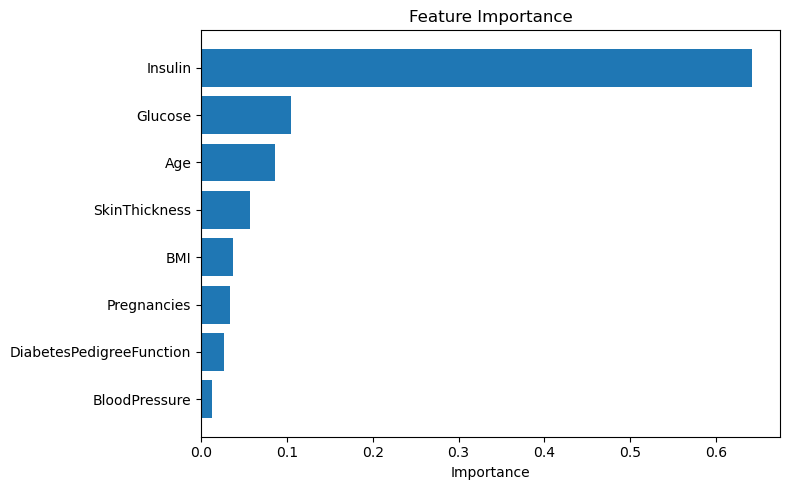

In [39]:
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances
importances = model.feature_importances_
features = X_train_resampled.columns

# Create a DataFrame
feat_imp = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
plt.barh(feat_imp['Feature'], feat_imp['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()
